In [1]:
import qiskit

import sys

sys.path.append("../../src/groundstate_prep")
from ground_state_prep_qiskit import get_error_from_sv
from fuzzy_bisection import fuzzy_bisection, fuzzy_bisection_noisy
from ground_state_prep import prepare_ground_state
from ground_state_prep_qiskit import qetu_rqc_oneLayer
from utils_gsp import qc_QETU_cf_heis_R

sys.path.append("../../src/lindbladian")
from lindbladian import circuit_implementation_lindbladian

sys.path.append("../../src/qpe")
from utils_qpe import controlled_trotterized_time_evolution

/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!

# side length of lattice
L = 4
# Hamiltonian parameters
J = (1,.5,1)
h = (0, 0, 0)

# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

dist = 1e-5
max_spectrum_length = 15
ground_energy_lower_bound = -10
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)

print(a_values)

Ground State Energy -6.744562646538037
a_max (0.9424503231290737-0j)
a_premax (0.8090164065892911-0j)
c1:  0.2094381769059862
c2:  2.0943917690598624
[0.94245032-0.00000000e+00j 0.80901641-0.00000000e+00j
 0.80901641-0.00000000e+00j 0.66913085-0.00000000e+00j
 0.50000144-0.00000000e+00j 0.50000144-1.46430026e-17j
 0.50000144+1.46430026e-17j 0.50000144-0.00000000e+00j
 0.50000144-0.00000000e+00j 0.50000144-0.00000000e+00j
 0.50000144-0.00000000e+00j 0.30901985-0.00000000e+00j
 0.30901985-0.00000000e+00j 0.10453277-0.00000000e+00j
 0.10453277-0.00000000e+00j 0.02675098-0.00000000e+00j]


In [3]:
from qiskit import Aer, execute, transpile
import rqcopt as oc
import scipy

def construct_heisenberg_local_term(J, h):
    X = np.array([[ 0.,  1.], [ 1.,  0.]])
    Y = np.array([[ 0., -1j], [ 1j,  0.]])
    Z = np.array([[ 1.,  0.], [ 0., -1.]])
    I = np.identity(2)
    
    hloc = (J[0]*np.kron(X, X) + 
            J[1]*np.kron(Y, Y) + 
            J[2]*np.kron(Z, Z) + 
            h*0.5*(np.kron(X, I) + np.kron(I, X))
           ) 
    return hloc

def trotterized_time_evolution(qc, coeffs, hloc, dt, L):
    Vlist = [scipy.linalg.expm(-1j*c*dt*hloc) for c in coeffs]
    Vlist_gates = []
    for V in Vlist:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)
    perms = [None if i % 2 == 0 else np.roll(range(L), -1) for i in range(len(coeffs))]
    for layer, qc_gate in enumerate(Vlist_gates):
        for j in range(L//2):
            if perms[layer] is not None:
                qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
            else:
                qc.append(qc_gate.to_gate(), [L-(2*j+1), L-(2*j+2)])

def qc_heisenberg_U(J1, J2, J3, c1, c2, nsteps, coeffs):
    t = c1/2
    dt = t / nsteps
    hloc1 = construct_heisenberg_local_term((J1, J2, 0), 0)
    hloc2 = construct_heisenberg_local_term((0, 0, J3), 0)
    qc_cU_ins = qiskit.QuantumCircuit(L)
    
    for i in range(nsteps):
        trotterized_time_evolution(qc_cU_ins, coeffs, hloc1, dt, L)
        trotterized_time_evolution(qc_cU_ins, coeffs, hloc2, dt, L)

    qc_cU_ins.p(-c2, 0)
    qc_cU_ins.x(0)
    qc_cU_ins.p(-c2, 0)
    qc_cU_ins.x(0)
    return qc_cU_ins

nsteps = 3
coeffs_blan = oc.SplittingMethod.blanes_moan().coeffs
qc_U_ins = qc_heisenberg_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan)

backend = Aer.get_backend("unitary_simulator")
qc_U_unit = execute(transpile(qc_U_ins), backend).result().get_unitary(qc_U_ins, L).data
U = scipy.linalg.expm(-1j*(c1/2*hamil + c2*np.identity(2**L)))

print("Time evolution encoding, absolute error: ", np.linalg.norm(U-qc_U_unit, ord=2))

Time evolution encoding, absolute error:  0.0317769015827838


In [4]:
def qc_heisenberg_cf_U(J1, J2, J3, c1, c2, nsteps, coeffs, dagger):
    t = c1/2
    dt = t / nsteps
    hloc1 = construct_heisenberg_local_term((J1, J2, 0), 0)
    hloc2 = construct_heisenberg_local_term((0, 0, J3), 0)
    qc_cU_ins = qiskit.QuantumCircuit(L+1)
    
    #H1=qib.HeisenbergHamiltonian(field, (J[0],J[1],0), (0,0,0)).as_matrix().toarray()
    #H2=qib.HeisenbergHamiltonian(field, (0, 0, J[2]), (0,0,0)).as_matrix().toarray()
    
    if dagger:
            qc_cU_ins.x(L)
    for i in range(nsteps):
        #controlled-hamil1
        qc_cU_ins.x(L)
        for j in range(L-1, -1, -1):
            if j % 2 == 1:
                qc_cU_ins.cz(L, j)
        qc_cU_ins.x(L)
        trotterized_time_evolution(qc_cU_ins, coeffs, hloc1, dt, L)
        #qc_cU_ins.unitary(scipy.linalg.expm(-1j*dt*H1), [l for l in range(L-1, -1, -1)])
        qc_cU_ins.x(L)
        for j in range(L-1, -1, -1):
            if j % 2 == 1:
                qc_cU_ins.cz(L, j)
        qc_cU_ins.x(L)

        #controlled-hamil2
        qc_cU_ins.x(L)
        for j in range(L-1, -1, -1):
            if j % 2 == 1:
                qc_cU_ins.cx(L, j)
        qc_cU_ins.x(L)
        trotterized_time_evolution(qc_cU_ins, coeffs, hloc2, dt, L)
        #qc_cU_ins.unitary(scipy.linalg.expm(-1j*dt*H2), [l for l in range(L-1, -1, -1)])
        qc_cU_ins.x(L)
        for j in range(L-1, -1, -1):
            if j % 2 == 1:
                qc_cU_ins.cx(L, j)
        qc_cU_ins.x(L)

    qc_cU_ins.cp(-c2, L,  0)
    qc_cU_ins.x(0)
    qc_cU_ins.cp(-c2, L, 0)
    qc_cU_ins.x(0)
    
    if dagger:
        qc_cU_ins.x(L)
    return qc_cU_ins
    
nsteps = 3
coeffs_blan = oc.SplittingMethod.blanes_moan().coeffs
qc_cU_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, False)
qc_cU_conj_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, True)

In [5]:
mu, d, c, phis_max_iter, = (0.9, 30, 0.95, 10)

qc_qetu, phis_0, qetu_mat = qetu_rqc_oneLayer(
                                    L, 0, 0, 1, mu,
                                    a_values, d=d, c=c, c2=0,
                                    max_iter_for_phis=phis_max_iter,
                                    split_U=1,
                                    steep=1e-6,
                                    #qc_U_custom=(qc_U_ins0, qc_U_ins1),
                                    #custom_qc_QETU_cf_R=qc_QETU_cf_heis_R,
                                    qc_cU_custom=(qc_cU_ins, qc_cU_conj_ins),
                                    H1=qib.HeisenbergHamiltonian(field, (J[0],J[1],J[2]), (0,0,0)).as_matrix().toarray(),
                                    H2=qib.HeisenbergHamiltonian(field, (0, 0, J[2]), (0,0,0)).as_matrix().toarray(),
                                    heis_c2=c2
)

dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.9004707807697423+0j)
F(a_premax)^2:  (0.0010397328884593077+0j)
QETU Error:  1.999436450847001


Absolute Error for the Eigenvalue:  10.74544259234537
State fidelity to the ground state:  0.0025496962507923146


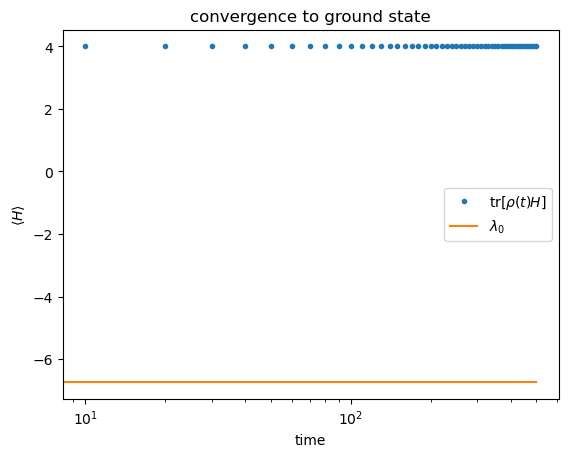

In [6]:
from qiskit.quantum_info import state_fidelity
from utils_lind import crandn

tau, nsteps = (10, 50)

A = np.array([[ 0.76357818+0.j        , -0.16549788-0.04454574j],
       [-0.16549788+0.04454574j,  0.39132369+0.j        ]])

end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, 
                                                                  tau=tau, nsteps=nsteps,
                                                                  A=A
                                                                 )

print("Absolute Error for the Eigenvalue: ", err)
print("State fidelity to the ground state: ", state_fidelity(end_state_lind, ground_state))
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()

In [47]:
# Firstly, we get a rough estimate of the eigenvalue through the expectation value measurement.
from qiskit import transpile, execute, Aer
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import state_fidelity

ground_state = eigenvectors_sort[:, 0]

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)

qc_RQC.initialize(np.kron(np.array([1,0]), end_state_lind))
for i in range(3):
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    aR = aR / np.linalg.norm(aR)
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)
    print("state_fidelity:", state_fidelity(aR[:2**L], ground_state))

state_fidelity: 0.2925386259533678
state_fidelity: 0.9519373495119958
state_fidelity: 0.9960685309289028


In [48]:
def Pr_counts(counts, j, zj, *zjplus1):
    # Helper Function to retrieve the probability of measuring the qubit number j (and optionally j+1)
    prob = 0
    nshots = 0
    for key, value in counts.items():
        nshots += value
    
    for bitstring, count in counts.items():
        bitstring = bitstring[::-1]
        bitstring = bitstring[:-1]
        
        L = len(bitstring)
        
        if not zjplus1:
            if bitstring[j] == str(zj):
                prob += count/nshots
        else:
            if j == L-1:
                if bitstring[j] == str(zj) and bitstring[0] == str(zjplus1[0]):
                    prob += count/nshots
            else:
                if bitstring[j] == str(zj) and bitstring[j+1] == str(zjplus1[0]):
                    prob += count/nshots
    return prob

def estimate_eigenvalue_counts2(counts, L):
    E = 0
    # For consistency with qib, upper range has to be L!
    for j in range(L):
        for zj in range(2):
            for zjplus1 in range(2):
                E = E + (((-1)**(zj + zjplus1)) * Pr_counts(counts, j, zj, zjplus1))
    return E

def estimate_eigenvalue_counts1(counts, L):
    E = 0
    for j in range(L):
        for zj in range(2):
            E = E + (((-1)**zj) * Pr_counts(counts, j, zj))
    return E

qc_Z = qc_RQC.copy()
qc_X = qc_Z.copy()
qc_X.h([i for i in range(L)])
qc_Y = qc_Z.copy()
qc_Y.p(-np.pi/2, [i for i in range(L)])
qc_Y.h([i for i in range(L)])

qc_X.measure([i for i in range(L+1)], [i for i in range(L+1)])
qc_Y.measure([i for i in range(L+1)], [i for i in range(L+1)])
qc_Z.measure([i for i in range(L+1)], [i for i in range(L+1)])

In [49]:
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel, errors

depolarizing_error = 1e-3
x1_error = errors.depolarizing_error(depolarizing_error*0.1, 1)
x2_error = errors.depolarizing_error(depolarizing_error, 2)
#x3_error = errors.depolarizing_error(10*depolarizing_error, 3)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(x2_error, ['cx', 'cy', 'cz'])
#noise_model.add_all_qubit_quantum_error(x3_error, ['ccx', 'ccy', 'ccz'])
print(noise_model)

nshots = 1e4
backend = Aer.get_backend("aer_simulator")
print("getting counts")
counts_dict1 = execute(transpile(qc_X), backend, noise_model=noise_model, basis_gates=noise_model.basis_gates,  shots=nshots).result().get_counts()
counts_dict2 = execute(transpile(qc_Y), backend, noise_model=noise_model, basis_gates=noise_model.basis_gates,  shots=nshots).result().get_counts()
counts_dict3 = execute(transpile(qc_Z), backend, noise_model=noise_model, basis_gates=noise_model.basis_gates,  shots=nshots).result().get_counts()    
print("gotten counts")
        
E_np = J[0] * estimate_eigenvalue_counts2(counts_dict1, L) +  J[1]*estimate_eigenvalue_counts2(counts_dict2, L) + J[2]*estimate_eigenvalue_counts2(counts_dict3, L) 
np.abs(E_np - eigenvalues_sort[0])

NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cy', 'cz', 'u2', 'u1', 'u3', 'cx']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx', 'cy', 'cz']
getting counts
gotten counts


0.36476264653803536

In [50]:
# Number of layers in the ground state preparation circuit

transpile(qc_X, basis_gates=noise_model.basis_gates).depth()

29653

In [28]:
# Expectation Value measurement delivers us:

E_np

-6.4434000000000005

In [62]:
# Expectation Value measurement falls off, hence we start with a large d=0
d = 0

dist = 1e-10
max_spectrum_length = 10**(d)

# Initial search starts with a larger margin, hence multiplication with 2!
# Estimation -6 is acquired through expectation value measurement!
ground_energy_lower_bound = -6 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.9
est_eig = 2*np.arccos(a_est)
print("Target Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Target Estimate: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

Target Absolute Error:  (0.031695232781898675+0j)
Target Estimate:  -6.712867413756138
Exact a:  (0.920577385177078-0j)


In [55]:
nsteps = 10
coeffs_blan = oc.SplittingMethod.blanes_moan().coeffs
qc_cU_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, False)
qc_cU_conj_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, True)

qc_U_ins = qc_heisenberg_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan)
backend = Aer.get_backend("unitary_simulator")
qc_U_unit = execute(transpile(qc_U_ins), backend).result().get_unitary(qc_U_ins, L).data
U = scipy.linalg.expm(-1j*(c1/2*hamil + c2*np.identity(2**L)))
print("Time evolution encoding, absolute error: ", np.linalg.norm(U-qc_U_unit, ord=2))


a_est = fuzzy_bisection_noisy(qc_qetu, L, 0, 0,
                              0, 1, 34, 1e-3, 0, 2, 0, a_values, 
                              1e-5, nshots=1e2, qetu_layers=3,
                              ground_state=eigenvectors_sort[:, 0],
                              qetu_initial_state=np.kron(np.array([1,0]), end_state_lind),
                              qc_cU_custom=(qc_cU_ins, qc_cU_conj_ins), split_U=1,
                             )

Time evolution encoding, absolute error:  0.3631688694907694
------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8845685278786686+0j)
F(a_premax)^2:  (0.00011586877341690724+0j)
state_fidelity: 0.9960685309289026
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cy', 'cu', 'u2', 'cx', 'cz', 'rz', 'sx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.64
------------------
x: 0.745
d:  34
left:  0.49
right:  1
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8661428713117583+0j)
F(a_premax)^2:  (0.00010000000000000129+0j)
state_fidelity: 0.9960685309289024
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cy', 'cu', 'u2', 'cx', 'cz', 'rz', 'sx', 'u3', 'u1']
  All-qubits error

In [64]:
nsteps = 10
coeffs_blan = oc.SplittingMethod.blanes_moan().coeffs
qc_cU_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, False)
qc_cU_conj_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, True)

qc_U_ins = qc_heisenberg_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan)
backend = Aer.get_backend("unitary_simulator")
qc_U_unit = execute(transpile(qc_U_ins), backend).result().get_unitary(qc_U_ins, L).data
U = scipy.linalg.expm(-1j*(c1/2*hamil + c2*np.identity(2**L)))
print("Time evolution encoding, absolute error: ", np.linalg.norm(U-qc_U_unit, ord=2))

a_est = fuzzy_bisection_noisy(qc_qetu, L, 0, 0,
                              0, 1, 34, 1e-3, 0, 2, 0, a_values, 
                              1e-4, nshots=1e2, qetu_layers=3,
                              ground_state=eigenvectors_sort[:, 0],
                              qetu_initial_state=np.kron(np.array([1,0]), end_state_lind),
                              qc_cU_custom=(qc_cU_ins, qc_cU_conj_ins), split_U=1,
                             )

Time evolution encoding, absolute error:  0.3631688694907694
------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8845685278786686+0j)
F(a_premax)^2:  (0.00011586877341690724+0j)
state_fidelity: 0.996068530928903
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cy', 'cu', 'u2', 'cx', 'cz', 'rz', 'sx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.49645
Not steep enough! Search ended!


In [56]:
a_est =  0.8674999999999999
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (0.07601364292727197+0j)
Estimated Eigenvalue:  -6.668549003610765


In [7]:
# Expectation Value measurement falls off, hence we start with a large d=0
d = -1

dist = 1e-10
max_spectrum_length = 10**(d)

# Initial search starts with a larger margin, hence multiplication with 2!
# Estimation -6 is acquired through expectation value measurement!
ground_energy_lower_bound = -6.7 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.6
est_eig = 2*np.arccos(a_est)
print("Target Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Target Estimate: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

Target Absolute Error:  (0.0035960935987855436+0j)
Target Estimate:  -6.740966552939251
Exact a:  (0.6442088264575795-0j)


In [9]:
nsteps = 200
coeffs_blan = oc.SplittingMethod.blanes_moan().coeffs
qc_cU_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, False)
qc_cU_conj_ins = qc_heisenberg_cf_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan, True)

qc_U_ins = qc_heisenberg_U(J[0], J[1], J[2], c1, c2, nsteps, coeffs_blan)
backend = Aer.get_backend("unitary_simulator")
qc_U_unit = execute(transpile(qc_U_ins), backend).result().get_unitary(qc_U_ins, L).data
U = scipy.linalg.expm(-1j*(c1/2*hamil + c2*np.identity(2**L)))
print("Time evolution encoding, absolute error: ", np.linalg.norm(U-qc_U_unit, ord=2))


a_est = fuzzy_bisection_noisy(qc_qetu, L, 0, 0,
                              0, 1, 34, 1e-3, 0, 2, 0, a_values, 
                              1e-5, nshots=1e2, qetu_layers=3,
                              ground_state=eigenvectors_sort[:, 0],
                              qetu_initial_state=np.kron(np.array([1,0]), end_state_lind),
                              qc_cU_custom=(qc_cU_ins, qc_cU_conj_ins), split_U=1,
                             )

Time evolution encoding, absolute error:  0.2732837743513061
------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  1.0
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.7758822258628864+0j)
F(a_premax)^2:  (0.8836013189975267+0j)
state_fidelity: 0.9819091594954804
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'cu', 'u3', 'rz', 'cz', 'sx', 'cx', 'cy']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.48
Not steep enough! Search ended!


In [ ]:
# We cannot get anything sensible from the above search but we showed that the lower bound 
# for L=4 is 1e-2 abs error for 1e-5 depolar. prob.

In [73]:
import h5py

def qc_U(two_qubit_gates, L, perms):
    U = qiskit.QuantumCircuit(L)
    for layer, qc_gate in enumerate(two_qubit_gates):
        assert L%2 == 0
        for j in range(L//2):
            if perms[layer] is not None:
                U.append(qc_gate.to_gate(), [perms[layer][2*j], perms[layer][2*j+1]])
            else:
                U.append(qc_gate.to_gate(), [2*j, 2*j+1])
    return U

t = c1/2
print("t:", t)
V_list1 = []
path1 = f"../../src/rqcopt/results/heisenberg1d_dynamics_opt_t{t}_dynamics_opt_layers9_1H.hdf5"
with h5py.File(path1, "r") as f:
    V_list1 = list(f["Vlist"])
perms = [None if i % 2 == 0 else np.roll(range(L), -1) for i in range(len(V_list1))]
qcs_rqc1 = []
for V in V_list1:
    qc_rqc = qiskit.QuantumCircuit(2)
    qc_rqc.unitary(V, [0, 1])
    qcs_rqc1.append(qc_rqc)
qc_U_ins1 = qc_U(qcs_rqc1, L, perms)

V_list2 = []
path2 = f"../../src/rqcopt/results/heisenberg1d_dynamics_opt_t{t}_dynamics_opt_layers3_2H.hdf5"
with h5py.File(path2, "r") as f:
    V_list2 = list(f["Vlist"])
qcs_rqc2 = []
for V in V_list2:
    qc_rqc = qiskit.QuantumCircuit(2)
    qc_rqc.unitary(V, [0, 1])
    qcs_rqc2.append(qc_rqc)
qc_U_ins2 = qc_U(qcs_rqc2, L, perms)


qc_U_ins = qiskit.QuantumCircuit(L)
qc_U_ins.append(qc_U_ins1, [i for i in range(L)])
qc_U_ins.append(qc_U_ins2, [i for i in range(L)])

backend = Aer.get_backend("unitary_simulator")
qc_U_unit = execute(transpile(qc_U_ins), backend).result().get_unitary(qc_U_ins, L).data
U = scipy.linalg.expm(-1j*t*hamil)
print("Time evolution encoding, absolute error: ", np.linalg.norm(U-qc_U_unit, ord=2))

t: 15.707963266948965
Time evolution encoding, absolute error:  1.6572859952488297
